In [1]:
import  matplotlib.pylab as plt
import numpy as np
from keras.applications.resnet50 import ResNet50
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator 
from keras.models import load_model
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from keras.applications.mobilenet import MobileNet
from keras.utils import multi_gpu_model
%load_ext autotime

Using TensorFlow backend.


### Loading Mura data

In [2]:
from utils import *

time: 20.2 ms


In [4]:
height, width = (256,256)
X_train, Y_train= load_mura_data(data_path='data/MURA-v1.1', bone_name='ALL',sample='train',target_size=(height, width))


INFO:utils.mura_utils:data/MURA-v1.1/train_x_ALL.pkl and data/MURA-v1.1/train_y_ALL.pkl exist, load directly
INFO:utils.util:loading data/MURA-v1.1/train_x_ALL.pkl
INFO:utils.util:loading data/MURA-v1.1/train_y_ALL.pkl
INFO:utils.util:prprocess images


time: 1min 23s


In [5]:
X_test, Y_test= load_mura_data(data_path='data/MURA-v1.1', bone_name='ALL',sample='valid',target_size=(height, width))

INFO:utils.mura_utils:data/MURA-v1.1/valid_x_ALL.pkl and data/MURA-v1.1/valid_y_ALL.pkl exist, load directly
INFO:utils.util:loading data/MURA-v1.1/valid_x_ALL.pkl
INFO:utils.util:loading data/MURA-v1.1/valid_y_ALL.pkl
INFO:utils.util:prprocess images


time: 3.54 s


In [6]:
X_train.shape

(36808, 256, 256)

time: 5.53 ms


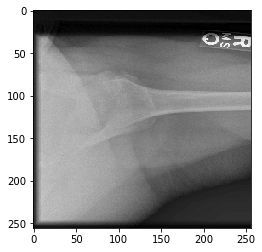

time: 171 ms


In [6]:
plt.imshow(X_train[0], cmap='gray')

### shuffle images 

In [7]:
from sklearn.utils import shuffle
shuffle_seed = 0 

X_train, Y_train = shuffle(X_train, Y_train,random_state = shuffle_seed)
X_test, Y_test   = shuffle(X_test, Y_test, random_state = shuffle_seed)

time: 22.4 s


In [8]:
X_train.shape, X_test.shape

((36808, 256, 256), (3197, 256, 256))

time: 3.94 ms


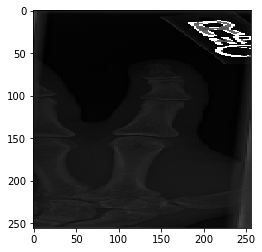

time: 153 ms


In [9]:
#using shuffle seed 
plt.imshow(X_train[0], cmap='gray')

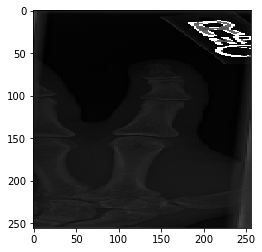

time: 135 ms


In [10]:
#randome shuffle 
plt.imshow(X_train[0], cmap='gray')

### Reshape the data to height * width * channel 

In [11]:
X_train = X_train.reshape(X_train.shape[0], height, width, 1)
X_test  = X_test.reshape(X_test.shape[0],height,width, 1)

time: 1.03 ms


In [12]:
X_test.shape

(3197, 256, 256, 1)

time: 3.67 ms


In [13]:
Y_train = np_utils.to_categorical(Y_train)
Y_test  = np_utils.to_categorical(Y_test)

time: 2.82 ms


### Mobile Net 0-15 Epochs 

In [16]:

model = MobileNet(input_shape= (height, width, 1), weights=None, classes=2)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=64, epochs = 15, validation_split=0.1,verbose=1)
model.save(filepath='trained_models/1_0_MobileNet_15.h5',overwrite=True)

Train on 33127 samples, validate on 3681 samples
Epoch 1/15
33127/33127 [==============================] - 395s 12ms/step - loss: 0.6732 - acc: 0.5970 - val_loss: 1.9466 - val_acc: 0.4023
Epoch 2/15
33127/33127 [==============================] - 380s 11ms/step - loss: 0.6212 - acc: 0.6547 - val_loss: 0.6640 - val_acc: 0.6240
Epoch 3/15
33127/33127 [==============================] - 380s 11ms/step - loss: 0.5835 - acc: 0.6920 - val_loss: 0.5847 - val_acc: 0.6900
Epoch 4/15
33127/33127 [==============================] - 380s 11ms/step - loss: 0.5581 - acc: 0.7144 - val_loss: 0.5478 - val_acc: 0.7251
Epoch 5/15
33127/33127 [==============================] - 380s 11ms/step - loss: 0.5414 - acc: 0.7279 - val_loss: 0.6139 - val_acc: 0.6732
Epoch 6/15
33127/33127 [==============================] - 380s 11ms/step - loss: 0.5270 - acc: 0.7395 - val_loss: 0.5842 - val_acc: 0.6952
Epoch 7/15
33127/33127 [==============================] - 380s 11ms/step - loss: 0.5194 - acc: 0.7450 - val_loss: 0.6

In [18]:
score = model.evaluate(X_test, Y_test, verbose=0)
score

[0.6450200716256722, 0.709415076550447]

time: 7.88 s


In [20]:
Y_test_hat = model.predict(X_test)
true_label = np.argmax(Y_test, axis = 1)
pred_label = np.argmax(Y_test_hat, axis=1)

kappa = cohen_kappa_score(y1=true_label, y2 = pred_label)
kappa 

0.4134604124046457

time: 8.68 s


### New train Moble Net 50 epochs

In [14]:
model = MobileNet(input_shape= (height, width, 1), weights=None, classes=2)
parallel_model = multi_gpu_model(model, gpus=2)
parallel_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
parallel_model.fit(X_train, Y_train, batch_size=64, epochs = 25, validation_split=0.1,verbose=1)
parallel_model.save(filepath='trained_models/1_0_MobileNet_25.h5',overwrite=True)


Train on 33127 samples, validate on 3681 samples
Epoch 1/25
33127/33127 [==============================] - 258s 8ms/step - loss: 0.6723 - acc: 0.6005 - val_loss: 0.8724 - val_acc: 0.4990
Epoch 2/25
33127/33127 [==============================] - 239s 7ms/step - loss: 0.6191 - acc: 0.6557 - val_loss: 0.6596 - val_acc: 0.6917
Epoch 3/25
33127/33127 [==============================] - 238s 7ms/step - loss: 0.5868 - acc: 0.6892 - val_loss: 0.7515 - val_acc: 0.5789
Epoch 4/25
33127/33127 [==============================] - 238s 7ms/step - loss: 0.5668 - acc: 0.7069 - val_loss: 0.5819 - val_acc: 0.7061
Epoch 5/25
33127/33127 [==============================] - 239s 7ms/step - loss: 0.5513 - acc: 0.7219 - val_loss: 0.6042 - val_acc: 0.7180
Epoch 6/25
33127/33127 [==============================] - 238s 7ms/step - loss: 0.5403 - acc: 0.7295 - val_loss: 0.6003 - val_acc: 0.6873
Epoch 7/25
33127/33127 [==============================] - 238s 7ms/step - loss: 0.5257 - acc: 0.7412 - val_loss: 0.5743 - v

In [16]:
score = parallel_model.evaluate(X_test, Y_test, verbose=0)
score

[1.0651795168313751, 0.6906474820330324]

time: 7.97 s


In [17]:
Y_test_hat = model.predict(X_test)
true_label = np.argmax(Y_test, axis = 1)
pred_label = np.argmax(Y_test_hat, axis=1)

kappa = cohen_kappa_score(y1=true_label, y2 = pred_label)
kappa 

0.3820983539536166

time: 8.11 s


### Inception Resnet V2

In [65]:
from keras.applications.inception_v3 import InceptionV3
model = InceptionV3(input_shape= (height, width, 1), weights=None, classes=2)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

time: 29.1 s


In [66]:

model.fit(X_train, Y_train, batch_size=64, epochs = 15, verbose=1)
model.save(filepath='trained_models/1_0_IncpV3_15.h5',overwrite=True)

Epoch 1/15
36808/36808 [==============================] - 345s 9ms/step - loss: 0.7037 - acc: 0.5937
Epoch 2/15
36808/36808 [==============================] - 311s 8ms/step - loss: 0.6195 - acc: 0.6642
Epoch 3/15
36808/36808 [==============================] - 314s 9ms/step - loss: 0.5829 - acc: 0.6981
Epoch 4/15
36808/36808 [==============================] - 313s 8ms/step - loss: 0.5673 - acc: 0.7138
Epoch 5/15
36808/36808 [==============================] - 303s 8ms/step - loss: 0.5495 - acc: 0.7278
Epoch 6/15
36808/36808 [==============================] - 303s 8ms/step - loss: 0.5355 - acc: 0.7394
Epoch 7/15
36808/36808 [==============================] - 303s 8ms/step - loss: 0.5218 - acc: 0.7515
Epoch 8/15
36808/36808 [==============================] - 303s 8ms/step - loss: 0.5127 - acc: 0.7585
Epoch 9/15
36808/36808 [==============================] - 303s 8ms/step - loss: 0.5000 - acc: 0.7663
Epoch 10/15
36808/36808 [==============================] - 303s 8ms/step - loss: 0.4956 - a

In [16]:
from keras.models import load_model
model = None 
model = load_model('trained_models/1_0_IncpV3_15.h5')
score = model.evaluate(X_test, Y_test, verbose=0)
score

[0.6178697747366855, 0.7191116669269737]

time: 1min 3s


In [18]:
Y_test_hat = model.predict(X_test)
true_label = np.argmax(Y_test, axis = 1)
pred_label = np.argmax(Y_test_hat, axis=1)

kappa = cohen_kappa_score(y1=true_label, y2 = pred_label)
kappa 

0.4274092281279518

time: 10.9 s


### Inception V3 Training from 15~30 epochs 

In [19]:
model.fit(X_train, Y_train, batch_size=64, epochs = 15, verbose=1)
model.save(filepath='trained_models/1_0_IncpV3_30.h5',overwrite=True)


Epoch 1/15
36808/36808 [==============================] - 309s 8ms/step - loss: 0.4344 - acc: 0.8080
Epoch 2/15
36808/36808 [==============================] - 292s 8ms/step - loss: 0.4253 - acc: 0.8117
Epoch 3/15
36808/36808 [==============================] - 292s 8ms/step - loss: 0.4108 - acc: 0.8182
Epoch 4/15
36808/36808 [==============================] - 292s 8ms/step - loss: 0.3978 - acc: 0.8256
Epoch 5/15
36808/36808 [==============================] - 292s 8ms/step - loss: 0.3850 - acc: 0.8329
Epoch 6/15
36808/36808 [==============================] - 292s 8ms/step - loss: 0.3650 - acc: 0.8442
Epoch 7/15
36808/36808 [==============================] - 291s 8ms/step - loss: 0.3451 - acc: 0.8542
Epoch 8/15
36808/36808 [==============================] - 291s 8ms/step - loss: 0.3221 - acc: 0.8647
Epoch 9/15
36808/36808 [==============================] - 292s 8ms/step - loss: 0.2981 - acc: 0.8770
Epoch 10/15
36808/36808 [==============================] - 292s 8ms/step - loss: 0.2755 - a

In [2]:
from keras.models import load_model
model = None 
model = load_model('trained_models/1_0_IncpV3_30.h5')
score = model.evaluate(X_test, Y_test, verbose=0)
print(f'Accuracy:{score}')


In [30]:
Y_test_hat = model.predict(X_test)
true_label = np.argmax(Y_test, axis = 1)
pred_label = np.argmax(Y_test_hat, axis=1)

kappa = cohen_kappa_score(y1=true_label, y2 = pred_label)
kappa 

0.47376820547844545

time: 15.6 s


### Parallel Trainning 

In [31]:
parallel_model = None 
parallel_model = load_model('trained_models/1_0_IncpV3_35.h5')
score = parallel_model.evaluate(X_test, Y_test, verbose=0)
print(f'Accuracy:{score}')

Y_test_hat = parallel_model.predict(X_test)
true_label = np.argmax(Y_test, axis = 1)
pred_label = np.argmax(Y_test_hat, axis=1)
kappa = cohen_kappa_score(y1=true_label, y2 = pred_label)
print(f'kappa:{kappa}') 

Accuracy:[1.7877851998690408, 0.709102283334747]
kappa:0.40622633460826896
time: 3min 42s


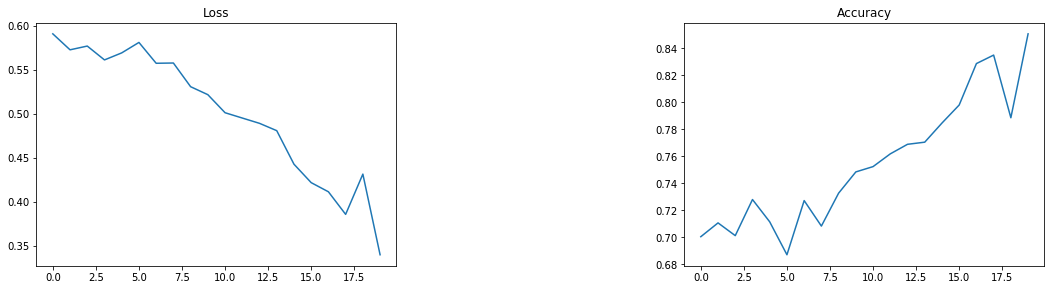

time: 320 ms


In [28]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(model.history.history['loss'])
plt.title('Loss')
plt.subplot(122)
plt.plot(model.history.history['acc'])
plt.title('Accuracy')
plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)
plt.show()